## Decision Trees

Decision trees are basically just nested if statements. The conditions in this if statements are what are learned by techniques that are rooted in Information Theory. 


### Information Theory
We measure weight by kilos, and water by litres, but how to measure information? The answer is Information Entropy. For instance, a page of a random book has more Entropy than the book itself because there's a lot of randomness in the page. On the other hand all the information is present in the book so it's obvious (less random = less Entropy)  


Entropy is used to choose the best splits in the DT. Our motive is to choose a split that maximizes the reduction in uncertainity. Eg: going from 50% certain to 100% certain is better than going from 50% to 75%. It is also related to variance. More variance = more uncertainity = more entropy. However, there's a subtle difference when both are used in multimodal distributions. In that, variance depends on where the peaks are, but entropy doesn't care. 

$$H(p) = \mathbb{E}(-log_2(p))$$

Also, denoted by

$$H(p) = -\sum p*log(p)$$

## Maximizing Information Gain

One of the algorithms that is used to create the decision tree is called ID3. It will recursively divide the tree into 2 by selecting the feature that will maximise the IG. For instance, if we have 2 features, it will split by both and check which of the features gave more IG. 

### Regularizing 
We can easily get 100% training accuracy by creating a decision tree of arbitrary length. We can avoid this by setting a max_depth parameter. 

### Algorithm for splitting

1. Sort X's for current column in order, sort Y in the same way
2. Find all boundary points where Y changes from one value to another
3. Calculate IG when splitting at each boundary
4. Keep the split which gives max IG

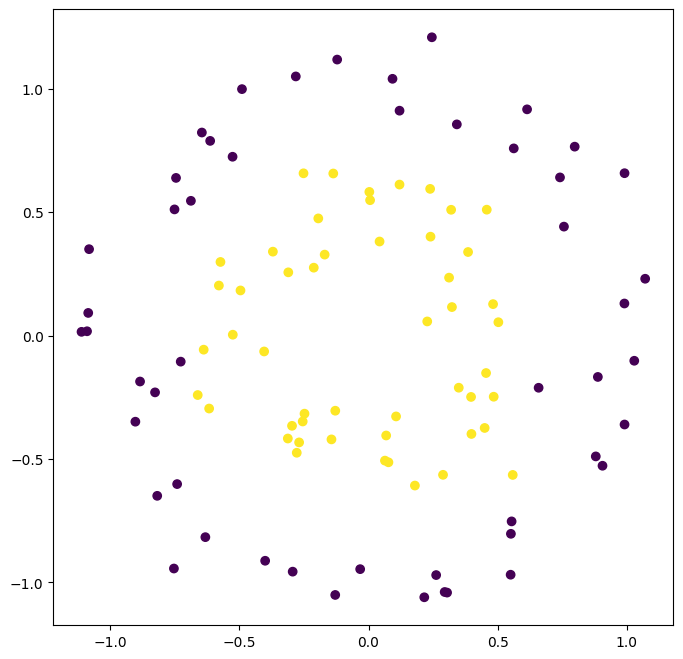

In [1]:

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

fig = plt.figure(figsize=(8, 8))
X, y = make_circles(factor=0.5, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y);

In [2]:
print(X,y)

[[-0.88451185 -0.1862348 ]
 [ 0.0769642  -0.51358095]
 [ 0.39681805 -0.24874026]
 [-0.5793543   0.20260402]
 [-0.72707212 -0.10572482]
 [ 0.90561863 -0.52752997]
 [ 0.3852369   0.33843953]
 [-0.49571712  0.18271349]
 [-0.14354924 -0.42078392]
 [-0.03241295 -0.94646302]
 [ 0.11997942  0.91105597]
 [ 0.39825857 -0.39871326]
 [-0.9026185  -0.34904211]
 [ 0.55816163 -0.5647029 ]
 [ 0.55106923 -0.80333363]
 [ 0.45757865  0.50997557]
 [ 0.06349408 -0.50674015]
 [-0.26875667 -0.43291786]
 [ 0.88765165 -0.16772877]
 [-0.25488862 -0.34818858]
 [-0.16987517  0.32793905]
 [ 0.28829031 -0.56427579]
 [ 0.65834202 -0.21158785]
 [-0.82645018 -0.23025505]
 [ 0.23989244  0.40061315]
 [ 1.07077517  0.23010102]
 [ 0.34922442 -0.21134603]
 [ 0.00594261  0.54842039]
 [ 0.00305765  0.58193818]
 [ 0.26171075 -0.97044832]
 [-1.11104473  0.01504955]
 [-0.61701868 -0.29571833]
 [ 0.09275405  1.04020952]
 [ 0.31171778  0.23458835]
 [-0.61308494  0.78866376]
 [ 0.21573329 -1.06045483]
 [ 0.99043571  0.12984558]
 

In [13]:
import numpy as np
class TreeNode:
    def __init__(self, curr_depth=0, max_depth=None):
        self.curr_depth = curr_depth
        self.max_depth = max_depth
    
    def fit(self, X, y):
        # Base case: if length is 1, or there's only 1 label
        # return the label
        if len(y) == 1 or len(set(y)) == 1:
            self.column = None
            self.split = None
            self.left = None
            self.right = None
            self.prediction = y[0]
        else:
            # find the best row for splitting
            columns = X.shape[1]
            max_ig = 0
            best_col = None
            best_split = None
            for col in range(columns):
                # for every column calculate the max
                # information gain. If it's better than
                # the current max, update it
                ig, split = self.find_split(X, y, col)
                if ig > max_ig:
                    max_ig = ig
                    best_col = col
                    best_split = split
            
            # this case is for 50-50 split when nothing
            # can be done, another base case
            if max_ig == 0:
                self.col = None
                self.split = None
                self.left = None
                self.right = None
                self.prediction = np.round(y.mean())
            else:
                # keep track of best column and best split
                self.column = best_col
                self.split = best_split
            
            # check if we're at max depth case, if yes
            # then stop here and save mean predictions
            if self.curr_depth == self.max_depth:
                self.left = None
                self.right = None
                self.prediction = [
                    # one for the left node: predict the mean y values
                    # where the X values are less than the split
                    np.round(y[X[:, best_col] < self.split].mean()),
                    # same goes for right
                    np.round(y[X[:, best_col] >= self.split].mean())
                ]
            else:
                # recurse
                left_indices = X[:, best_col] < best_split
                X_left = X[left_indices]
                y_left = y[left_indices]
                # create a new node
                self.left = TreeNode(self.depth + 1, self.max_depth)
                self.left.fit(X_left, y_left)
                
                # same for right
                right_indices = X[:, best_col] >= best_split
                X_right = X[right_indices]
                y_right = y[right_indices]
                # create a new node
                self.right = TreeNode(self.depth + 1, self.max_depth)
                self.right.fit(X_right, y_right)
    
    def find_split(self, X, y, col):
        x_values = X[:, col]
        sort_idx = np.argsort(x_values)
        x_values = x_values[sort_idx]
        y_values = y[sort_idx]
        boundaries = np.nonzero(y_values[:-1] != y_values[1:])
        #print("BS: {}".format(boundaries.shape))
        best_split = None
        max_ig = 0
        for boundary in boundaries:
            # average the current and next x value to get the split
            # the rule will be:
            # 1. on the left: data < split
            # 2. on the right: data >= split
            split = (X[boundary] + X[boundary + 1]) / 2
            ig = self.information_gain(X, y, split)
            if ig > max_ig:
                best_split = boundary
                max_ig = ig
        return max_ig, best_split
    
    def binary_entropy(y):
        p1 = (y==1).sum() / len(y)
        p0 = 1 - p1
        if p1 == 1 or p1 == 0:
            return 0
        else:
            return -p1 * np.log2(p1) - p0 * np.log2(p0)
    
    def information_gain(self, x, y, split):
        # y for inputs less than split, left node of the tree
        y0 = y[x < split]
        # same for right node
        y1 = y[x >= split]
        N = len(y)
        y0len = len(y0)
        # base case where the split is in the beginning
        # or the end
        if y0len == 0 or y0len == N:
            return 0
        p0 = len(y0) / N
        p1 = 1 - p0
        return self.binary_entropy(y) - p0 * binary_entropy(y0) - p1 * binary_entropy(y1)

In [15]:
clf = TreeNode(curr_depth=0, max_depth=2)
clf.fit(X,y)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [54]:
y = np.array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [55]:
np.nonzero(y[:-1] != y[1:])

(array([2, 5, 6, 7, 8], dtype=int64),)

In [45]:
s = np.argsort(x)

In [47]:
x[s]

array([5, 7, 9, 9])

In [48]:
s

array([1, 3, 0, 2], dtype=int64)

In [50]:
x[[1, 3, 0, 2]]

array([5, 7, 9, 9])